# Data sources comparison [__updated file__]

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime as dt

In [2]:
# %matplotlib auto
%matplotlib inline

## 1. Loading SoDa data

In [3]:
df = pd.read_csv(
    '../Data/SoDa/SoDa_buoy.csv',
    sep=';',
    comment='#',
    usecols=[ 'Date', 'Time', 'Global Horiz', 'Clear-Sky', 'Temperature', 'Wind speed', 'Wind direction']
)

dates = pd.DatetimeIndex(df['Date'])
df.drop(
    labels=df[(dates.year < 2018) | (dates.year > 2020) | (dates.month < 5) | (dates.month > 9)].index,
    axis=0,
    inplace=True
)
df['Time'] = np.array([int(h.split(':')[0]) + np.ceil(int(h.split(':')[1])/60) for h in df['Time']], dtype='int')

df = df.rename(
    columns={
        'Date': 'date',
        'Time': 'hour',
        'Global Horiz': 'ghi',
        'Clear-Sky': 'cs',
        'Temperature': 'T_rean',
        'Wind speed': 'ws_rean',
        'Wind direction': 'wd_rean'
    }
)

SoDa = df.groupby(['date', 'hour']).mean().reset_index()
SoDa

,date,hour,ghi,cs,T_rean,ws_rean,wd_rean
0,2018-05-01,1,0.0,0.0,288.82,4.54,239.94
1,2018-05-01,2,0.0,0.0,288.74,3.44,238.35
2,2018-05-01,3,0.0,0.0,288.68,4.19,218.18
3,2018-05-01,4,0.0,0.0,288.75,5.73,218.58
4,2018-05-01,5,4.0,11.0,288.80,4.05,231.82
...,...,...,...,...,...,...,...
11011,2020-09-30,20,0.0,0.0,291.42,2.69,226.42
11012,2020-09-30,21,0.0,0.0,291.46,3.05,233.01
11013,2020-09-30,22,0.0,0.0,291.53,3.41,233.38
11014,2020-09-30,23,0.0,0.0,291.62,3.73,230.24


## 2. Loading Copernicus data

### Checking file content

In [4]:
cop = nc.Dataset('../Data/copernicus.nc')
print(cop)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    bulletin_type: reanalysis
    institution: Hellenic Centre for Marine Research (HCMR)- Athens,Greece
    source: MEDWAM3
    credit: Copernicus Marine Environment Monitoring Service (CMEMS)
    contact: servicedesk.cmems@mercator-ocean.eu
    producer: CMEMS-MED Monitoring and Forecasting Centre
    references: Please check in CMEMS catalogue the INFO section for product MEDSEA_MULTIYEAR_WAV_006_012 - http://marine.copernicus.eu
    comment: Please check in CMEMS catalogue the INFO section for product MEDSEA_MULTIYEAR_WAV_006_012 - http://marine.copernicus.eu
    Conventions: CF-1.6
    area: MED
    bulletin_date: 2021-06-01
    FROM_ORIGINAL_FILE__field_type: hourly_instantaneous_at_time_field
    title: Wave fields (2D) - Hourly Instantaneous
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    history: Data extracted from dataset http://localhost:8080/thredds/dodsC/med-hcmr

In [5]:
for v in cop.dimensions.values():
    print(v)

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 18289
<class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 97
<class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 97


In [6]:
for v in cop.variables.values():
    print(v, end=' ;\n\n')

<class 'netCDF4._netCDF4.Variable'>
int16 VHM0_WW(time, latitude, longitude)
    scale_factor: 0.001
    add_offset: 0.0
    _FillValue: -32767
    missing_value: -32767
    long_name: Spectral significant wind wave height
    standard_name: sea_surface_wind_wave_significant_height
    coordinates: time latitude longitude
    units: m
    type_of_analysis: spectral analysis
    WMO: 102
    _ChunkSizes: [   1  380 1307]
unlimited dimensions: 
current shape = (18289, 97, 97)
filling on ;

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    standard_name: latitude
    units: degrees_north
    long_name: latitude
    axis: Y
    valid_min: 41.979168
    valid_max: 45.979168
    step: 0.042
    _CoordinateAxisType: Lat
unlimited dimensions: 
current shape = (97,)
filling on, default _FillValue of 9.969209968386869e+36 used ;

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: seconds since 1970-01-01 00:00:00
    calendar: standard
    long_name: time
    stan

In [7]:
def convertUnixTime(uxt):
    if type(uxt) == np.ma.core.MaskedArray:
        return dt.datetime.fromtimestamp(int(uxt.data))
    else:
        return dt.datetime.fromtimestamp(int(uxt))

In [8]:
print(f"Latitude limits : {cop['latitude'][0]} - {cop['latitude'][-1]}")
print(f"Longitude limits : {cop['longitude'][0]} - {cop['longitude'][-1]}")
print(f"Time limits : {convertUnixTime(cop['time'][0])} - {convertUnixTime(cop['time'][-1])}")

Latitude limits : 41.97916793823242 - 45.97916793823242
Longitude limits : 5.500000476837158 - 9.500000953674316
Time limits : 2018-05-01 01:00:00 - 2020-06-01 01:00:00


In [9]:
convertedTime = np.empty(shape=(18289,), dtype='U20')
for k, uxt in enumerate(cop['time'][:].data):
    convertedTime[k] = convertUnixTime(uxt)
convertedTime

array(['2018-05-01 01:00:00', '2018-05-01 02:00:00',
       '2018-05-01 03:00:00', ..., '2020-05-31 23:00:00',
       '2020-06-01 00:00:00', '2020-06-01 01:00:00'], dtype='<U20')

In [10]:
mask = np.zeros(shape=(18289,), dtype='bool')
for k, t in enumerate(convertedTime):
    month = int(t[5:7])
    if 4 < month < 10 and not t.endswith('05-01 00:00:00'):
        mask[k] = True
    if t.endswith('10-01 00:00:00'):
        mask[k] = True
np.count_nonzero(mask)

8089

In [11]:
# Expected

inYear = 31*3 + 30*2
days = inYear*2 + 31 # complete 2018 and 2019 + may 2020
24*days

8088

### Find lat, long

In [12]:
i = np.argmin(np.abs(cop['latitude'][:].data - 43.38))
j = np.argmin(np.abs(cop['longitude'][:].data - 7.83))

print(i, j)

34 56


### Loading

In [13]:
when = np.char.split(convertedTime[mask], ' ')

dates = [d[0] for d in when]
hours = [d[1][:2] for d in when]

toAdd = np.arange(
    dt.datetime.timestamp(dt.datetime.strptime('2020-06-01 02:00:00', '%Y-%m-%d %H:%M:%S')),
    dt.datetime.timestamp(dt.datetime.strptime('2020-10-01 01:00:00', '%Y-%m-%d %H:%M:%S')),
    3600 # returns unix time in seconds
)

daysToAdd = []
hoursToAdd = []
for uxt in toAdd:
    d = convertUnixTime(uxt)
    daysToAdd.append(str(d)[:10])
    hoursToAdd.append(str(d)[11:13])

In [14]:
dates = np.array(dates + daysToAdd, dtype='U10')
hours = np.array(hours + hoursToAdd, dtype='int')

for k, h in enumerate(hours):
    if h == 0:
        newdate = dt.datetime.timestamp(dt.datetime.strptime(dates[k], '%Y-%m-%d')) - 24*3600
        dates[k] = dt.datetime.fromtimestamp(newdate)
        hours[k] = 24

In [15]:
df = pd.DataFrame()
df['date'] = dates
df['time'] = hours
df['shww_rean'] = np.nan
df['mpww_rean'] = np.nan
df.loc[df.index[:8089], 'shww_rean'] = cop['VHM0_WW'][mask, i, j].data
df.loc[df.index[:8089], 'mpww_rean'] = cop['VTM01_WW'][mask, i, j].data
df

,date,time,shww_rean,mpww_rean
0,2018-05-01,1,0.642,3.199
1,2018-05-01,2,0.535,2.961
2,2018-05-01,3,0.713,3.470
3,2018-05-01,4,0.733,3.450
4,2018-05-01,5,0.539,2.937
...,...,...,...,...
11011,2020-09-30,20,NaN,NaN
11012,2020-09-30,21,NaN,NaN
11013,2020-09-30,22,NaN,NaN
11014,2020-09-30,23,NaN,NaN


In [16]:
(SoDa['date'] == df['date']).all(), (SoDa['hour'] == df['time']).all()

(True, True)

### Merge

In [17]:
for key in ['ghi', 'cs', 'T_rean', 'ws_rean', 'wd_rean']:
    df[key] = SoDa[key]
df

,date,time,shww_rean,mpww_rean,ghi,cs,T_rean,ws_rean,wd_rean
0,2018-05-01,1,0.642,3.199,0.0,0.0,288.82,4.54,239.94
1,2018-05-01,2,0.535,2.961,0.0,0.0,288.74,3.44,238.35
2,2018-05-01,3,0.713,3.470,0.0,0.0,288.68,4.19,218.18
3,2018-05-01,4,0.733,3.450,0.0,0.0,288.75,5.73,218.58
4,2018-05-01,5,0.539,2.937,4.0,11.0,288.80,4.05,231.82
...,...,...,...,...,...,...,...,...,...
11011,2020-09-30,20,NaN,NaN,0.0,0.0,291.42,2.69,226.42
11012,2020-09-30,21,NaN,NaN,0.0,0.0,291.46,3.05,233.01
11013,2020-09-30,22,NaN,NaN,0.0,0.0,291.53,3.41,233.38
11014,2020-09-30,23,NaN,NaN,0.0,0.0,291.62,3.73,230.24


## 3. Loading buoy data

In [18]:
duration = {5: 31, 6: 30, 7: 31, 8: 31, 9: 30}
hADay = set(range(24))

### Loading each file separately

In [19]:
def load(year, month, printMissing=False):

    fileName = f'../Data/Buoy/marine.{year}0{month}.csv.gz'
    db = pd.read_csv(
        fileName, 
        sep=';',
        usecols=['numer_sta', 'date', 't', 'dd', 'ff', 'HwaHwa', 'PwaPwa'],
        compression='gzip'
    )

    # Clean file

    db.drop(
        labels=db[np.array(db['numer_sta'], dtype='str') != '6100001'].index,
        axis=0,
        inplace=True
    )
    db.drop(labels='numer_sta', axis=1, inplace=True)

    # Date format

    buoyDate, buoyHour = [], []
    for date in np.array(db['date'], dtype='str'):
        assert date[:4] == f'{year}'
        assert date[4:6] == f'0{month}'
        buoyDate.append(f'{year}-0{month}-' + date[6:8])
        buoyHour.append(date[8:10])
    db['date'] = np.array(buoyDate, dtype='str')
    db['hour'] = np.array(buoyHour, dtype='int')

    db[db == 'mq'] = np.nan

    db = db.astype(
        dtype={
            't': 'float',
            'dd': 'float',
            'ff': 'float',
            'HwaHwa': 'float',
            'PwaPwa': 'float'
        }
    )

    db = db.groupby(['date', 'hour']).mean().reset_index()

    # Complete gaps in file

    for d in range(1, duration[month] + 1):
        date = f'{year}-0{month}-' + '0'*(1 - int(d > 9)) + str(d)
        hours = set(db.loc[db['date'] == date, 'hour'])
        missingHours = hADay.difference(hours)

        if printMissing and len(hours) == 0:
            print(f'Missing entire day : ' + date)
        elif printMissing and len(missingHours) > 0:
            print(f'Missing hours {missingHours} during day ' + date)
        
        for h in missingHours:
            row = {
                'date': date,
                'hour': h,
                't': np.nan,
                'dd': np.nan,
                'ff': np.nan,
                'HwaHwa': np.nan,
                'PwaPwa': np.nan
            }
            db = db.append(row, ignore_index=True)
    return db.sort_values(by=['date', 'hour'], axis=0, ignore_index=True)

In [20]:
load(2018, 9, True)

Missing hours {17, 18, 13} during day 2018-09-22


/var/folders/0c/_q6vlmwj4ddf849gppmj2_4r0000gn/T/ipykernel_4472/1539466157.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  db = db.append(row, ignore_index=True)
/var/folders/0c/_q6vlmwj4ddf849gppmj2_4r0000gn/T/ipykernel_4472/1539466157.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  db = db.append(row, ignore_index=True)
/var/folders/0c/_q6vlmwj4ddf849gppmj2_4r0000gn/T/ipykernel_4472/1539466157.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  db = db.append(row, ignore_index=True)


,date,hour,t,dd,ff,HwaHwa,PwaPwa
0,2018-09-01,0,296.35,40.0,10.6,1.25,4.10
1,2018-09-01,1,296.75,40.0,9.8,1.55,4.80
2,2018-09-01,2,296.25,40.0,9.4,1.60,4.75
3,2018-09-01,3,295.85,50.0,9.2,1.55,4.75
4,2018-09-01,4,296.15,50.0,8.4,1.50,4.70
...,...,...,...,...,...,...,...
715,2018-09-30,19,294.65,250.0,2.9,0.50,3.80
716,2018-09-30,20,294.85,250.0,3.6,0.50,3.80
717,2018-09-30,21,294.85,240.0,4.1,0.50,3.75
718,2018-09-30,22,294.55,210.0,5.2,0.50,3.65


### Merging all buoy files

In [21]:
def merge():
    dbl = []
    for year in range(2018, 2021):
        for month in range(5, 10):
            dbl.append(load(year, month))
    return pd.concat(dbl, axis=0, ignore_index=True)

In [22]:
import warnings as w

w.filterwarnings('ignore')

buoy = merge()
buoy

,date,hour,t,dd,ff,HwaHwa,PwaPwa
0,2018-05-01,0,289.35,220.0,7.0,1.5,6.0
1,2018-05-01,1,289.35,230.0,6.2,1.4,6.0
2,2018-05-01,2,289.25,230.0,5.8,1.4,6.0
3,2018-05-01,3,289.15,240.0,5.2,1.3,6.0
4,2018-05-01,4,289.05,240.0,4.3,1.3,6.0
...,...,...,...,...,...,...,...
11011,2020-09-30,19,292.35,230.0,3.4,0.4,3.0
11012,2020-09-30,20,292.05,230.0,3.7,0.3,4.0
11013,2020-09-30,21,292.05,230.0,3.0,0.3,4.0
11014,2020-09-30,22,292.15,210.0,3.2,0.3,4.0


In [23]:
(buoy['date'] == df['date']).all(), (buoy['hour'] + 1 == df['time']).all()

(True, True)

We now have a compatible format (exactly one value for each hour of each day of May, June, July, August and Septembre of 2018, 2019 and 2020)

## 4. Join all files

### Observations files

In [24]:
df['ws'] = buoy['ff']
df['wd'] = buoy['dd']
df['shww'] = buoy['HwaHwa']
df['mpww'] = buoy['PwaPwa']
df['T'] = buoy['t']
df

,date,time,shww_rean,mpww_rean,ghi,cs,T_rean,ws_rean,wd_rean,ws,wd,shww,mpww,T
0,2018-05-01,1,0.642,3.199,0.0,0.0,288.82,4.54,239.94,7.0,220.0,1.5,6.0,289.35
1,2018-05-01,2,0.535,2.961,0.0,0.0,288.74,3.44,238.35,6.2,230.0,1.4,6.0,289.35
2,2018-05-01,3,0.713,3.470,0.0,0.0,288.68,4.19,218.18,5.8,230.0,1.4,6.0,289.25
3,2018-05-01,4,0.733,3.450,0.0,0.0,288.75,5.73,218.58,5.2,240.0,1.3,6.0,289.15
4,2018-05-01,5,0.539,2.937,4.0,11.0,288.80,4.05,231.82,4.3,240.0,1.3,6.0,289.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2020-09-30,20,NaN,NaN,0.0,0.0,291.42,2.69,226.42,3.4,230.0,0.4,3.0,292.35
11012,2020-09-30,21,NaN,NaN,0.0,0.0,291.46,3.05,233.01,3.7,230.0,0.3,4.0,292.05
11013,2020-09-30,22,NaN,NaN,0.0,0.0,291.53,3.41,233.38,3.0,230.0,0.3,4.0,292.05
11014,2020-09-30,23,NaN,NaN,0.0,0.0,291.62,3.73,230.24,3.2,210.0,0.3,4.0,292.15


### NWP files (ECMWF)

In [25]:
def findIndex(la, lo):
    lat = int(np.rint((46 - la)*8))
    long = int(np.rint((lo - 5.5)*8))
    return lat, long

m, n = findIndex(43.38, 7.83)

In [26]:
ds = nc.Dataset('../clean/Data4/nwp.nc')
df['ghi_nwp'] = ds['ghi'][:153*3, 1:, m, n].data.reshape((11016,))
df['T_nwp'] = ds['t'][:153*3, 1:, m, n].data.reshape((11016,))
df['wd_nwp'] = ds['wd'][:153*3, 1:, m, n].data.reshape((11016,))
df['ws_nwp'] = ds['ws'][:153*3, 1:, m, n].data.reshape((11016,))
df['mpww_nwp'] = ds['mpww'][:153*3, 1:, m, n].data.reshape((11016,))
df['shww_nwp'] = ds['shww'][:153*3, 1:, m, n].data.reshape((11016,))

### Clear sky file

In [27]:
dcs = nc.Dataset('../Data/cls.nc')

m = np.argmin(np.abs(dcs['lat'][:].data - 43.38))
n = np.argmin(np.abs(dcs['lon'][:].data - 7.83))

m, n

(11, 19)

In [28]:
df['cs_mod'] = 0
df.loc[df.index[:3672], 'cs_mod'] = dcs['GHIcls'][m, n, 121:274, :].reshape((3672,))
df.loc[df.index[3672:7344], 'cs_mod'] = dcs['GHIcls'][m, n, 121:274, :].reshape((3672,))
df.loc[df.index[7344:], 'cs_mod'] = dcs['GHIcls'][m, n, 121:274, :].reshape((3672,))

In [29]:
df[
    [
        'date',
        'time',
        'ghi',
        'ghi_nwp',
        'T',
        'T_rean',
        'T_nwp',
        'ws',
        'ws_rean',
        'ws_nwp',
        'wd',
        'wd_rean',
        'wd_nwp'
    ]
].head(1390)

,date,time,ghi,ghi_nwp,T,T_rean,T_nwp,ws,ws_rean,ws_nwp,wd,wd_rean,wd_nwp
0,2018-05-01,1,0.0,0.000000,289.35,288.82,289.840730,7.0,4.54,7.753966,220.0,239.94,237.109060
1,2018-05-01,2,0.0,0.000000,289.35,288.74,289.785228,6.2,3.44,7.650345,230.0,238.35,232.918395
2,2018-05-01,3,0.0,0.000000,289.25,288.68,289.708639,5.8,4.19,6.704539,230.0,218.18,239.042369
3,2018-05-01,4,0.0,0.000000,289.15,288.75,289.653621,5.2,5.73,5.817804,240.0,218.58,252.273447
4,2018-05-01,5,4.0,8.540340,289.05,288.80,289.603451,4.3,4.05,4.577616,240.0,231.82,257.848185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,2018-06-27,18,168.0,142.613582,296.05,295.75,296.450195,5.1,4.44,5.417498,220.0,221.31,225.839599
1386,2018-06-27,19,37.0,40.147819,296.05,295.52,296.387263,5.0,4.21,4.972698,220.0,220.49,221.319008
1387,2018-06-27,20,0.0,0.355290,295.95,295.28,296.307699,5.3,3.90,4.934577,210.0,220.74,216.578705
1388,2018-06-27,21,0.0,0.000000,295.85,295.16,296.103396,5.7,3.44,5.286158,220.0,222.07,216.023930


In [30]:
df[['date', 'time', 'ghi', 'ghi_nwp', 'cs', 'cs_mod']]

,date,time,ghi,ghi_nwp,cs,cs_mod
0,2018-05-01,1,0.0,0.00000,0.0,0.0
1,2018-05-01,2,0.0,0.00000,0.0,0.0
2,2018-05-01,3,0.0,0.00000,0.0,0.0
3,2018-05-01,4,0.0,0.00000,0.0,0.0
4,2018-05-01,5,4.0,8.54034,11.0,13.6
...,...,...,...,...,...,...
11011,2020-09-30,20,0.0,0.00000,0.0,0.0
11012,2020-09-30,21,0.0,0.00000,0.0,0.0
11013,2020-09-30,22,0.0,0.00000,0.0,0.0
11014,2020-09-30,23,0.0,0.00000,0.0,0.0


## 5. Compare available data

### Graphics

In [48]:
color = ['tab:blue', 'tab:cyan', 'tab:pink']

def series(cat: str, source: pd.DataFrame = df):
    plt.figure(figsize=(10, 4), dpi=600)
    for c, suff in zip(color, ['', '_rean', '_nwp']):
        name = cat + suff
        plt.plot(source.index, source[name], label=name, color=c)
    plt.legend(fontsize=10)
    plt.xlabel('t (h)', fontsize=10)
    # plt.title(cat + ' comparison')

In [32]:
def histogram(cat: str, source: pd.DataFrame = df):
    fig, ax = plt.subplots(2, sharex=True)
    suffs = ['', '_nwp']
    for c, suff in zip(color[:2], suffs):
        name = cat + suff
        ax[0].hist(source[name], alpha=.7, bins=100, label=name, density=True, color=c)
    ax[1].boxplot(
        [source[cat + s].dropna(axis=0, how='any') for s in suffs],
        vert=False,
        labels=[cat + s for s in suffs],
        medianprops={'color': 'tab:purple'},
        flierprops={'marker': 'x', 'markersize': 2}
    )
    ax[0].legend()
    fig.tight_layout()
    # fig.suptitle(cat + ' distribution comparison')

In [40]:
from scipy.stats import linregress

def plane(cat: str, type1: str = 'obs', type2: str = 'nwp', source: pd.DataFrame = df):

    fs=10

    x = cat if type1 == 'obs' else cat + '_' + type1
    y = cat if type2 == 'obs' else cat + '_' + type2
    title = cat + ' regression'
    xlab = cat + ' ' + type1
    ylab = cat + ' ' + type2

    data = source[[x, y]].dropna(axis=0, how='any')
    a, b, _, _, _ = linregress(data[x], data[y])
    plt.figure(figsize=(10, 4), dpi=600)
    plt.plot(data[x], data[x], color='tab:orange', alpha=.6, label='Id')
    plt.plot(data[x], a*data[x] + b, color='tab:red', label='Linear regression a={:.2f}, b={:.2f}'.format(a, b))
    plt.scatter(data[x], data[y], s=3, marker='+', alpha=.6)
    plt.xlabel(xlab, fontsize=fs)
    plt.ylabel(ylab, fontsize=fs)
    # plt.title(title)
    plt.legend(fontsize=fs)

### Statistics

In [34]:
def corr(cat: str, source: pd.DataFrame = df):
    cols = [cat + suff for suff in ['', '_rean', '_nwp']]
    print('======== ' + cat + ' correlations ========')
    print(np.corrcoef(source[cols].dropna(axis=0, how='any').T))

In [35]:
from sklearn.metrics import mean_squared_error

def RMSE(cat: str, source: pd.DataFrame = df):
    cols = [cat + suff for suff in ['', '_rean', '_nwp']]
    series = source[cols].dropna(axis=0, how='any')
    print('============ ' + cat + ' RMSEs ============')
    raw_rean = mean_squared_error(series[cat], series[cat + '_rean'], squared=False)
    raw_nwp = mean_squared_error(series[cat], series[cat + '_nwp'], squared=False)
    rean_nwp = mean_squared_error(series[cat + '_nwp'], series[cat + '_rean'], squared=False)
    print(np.array([[0., raw_rean, raw_nwp], [raw_rean, 0., rean_nwp], [raw_nwp, rean_nwp, 0.]]))

### Results

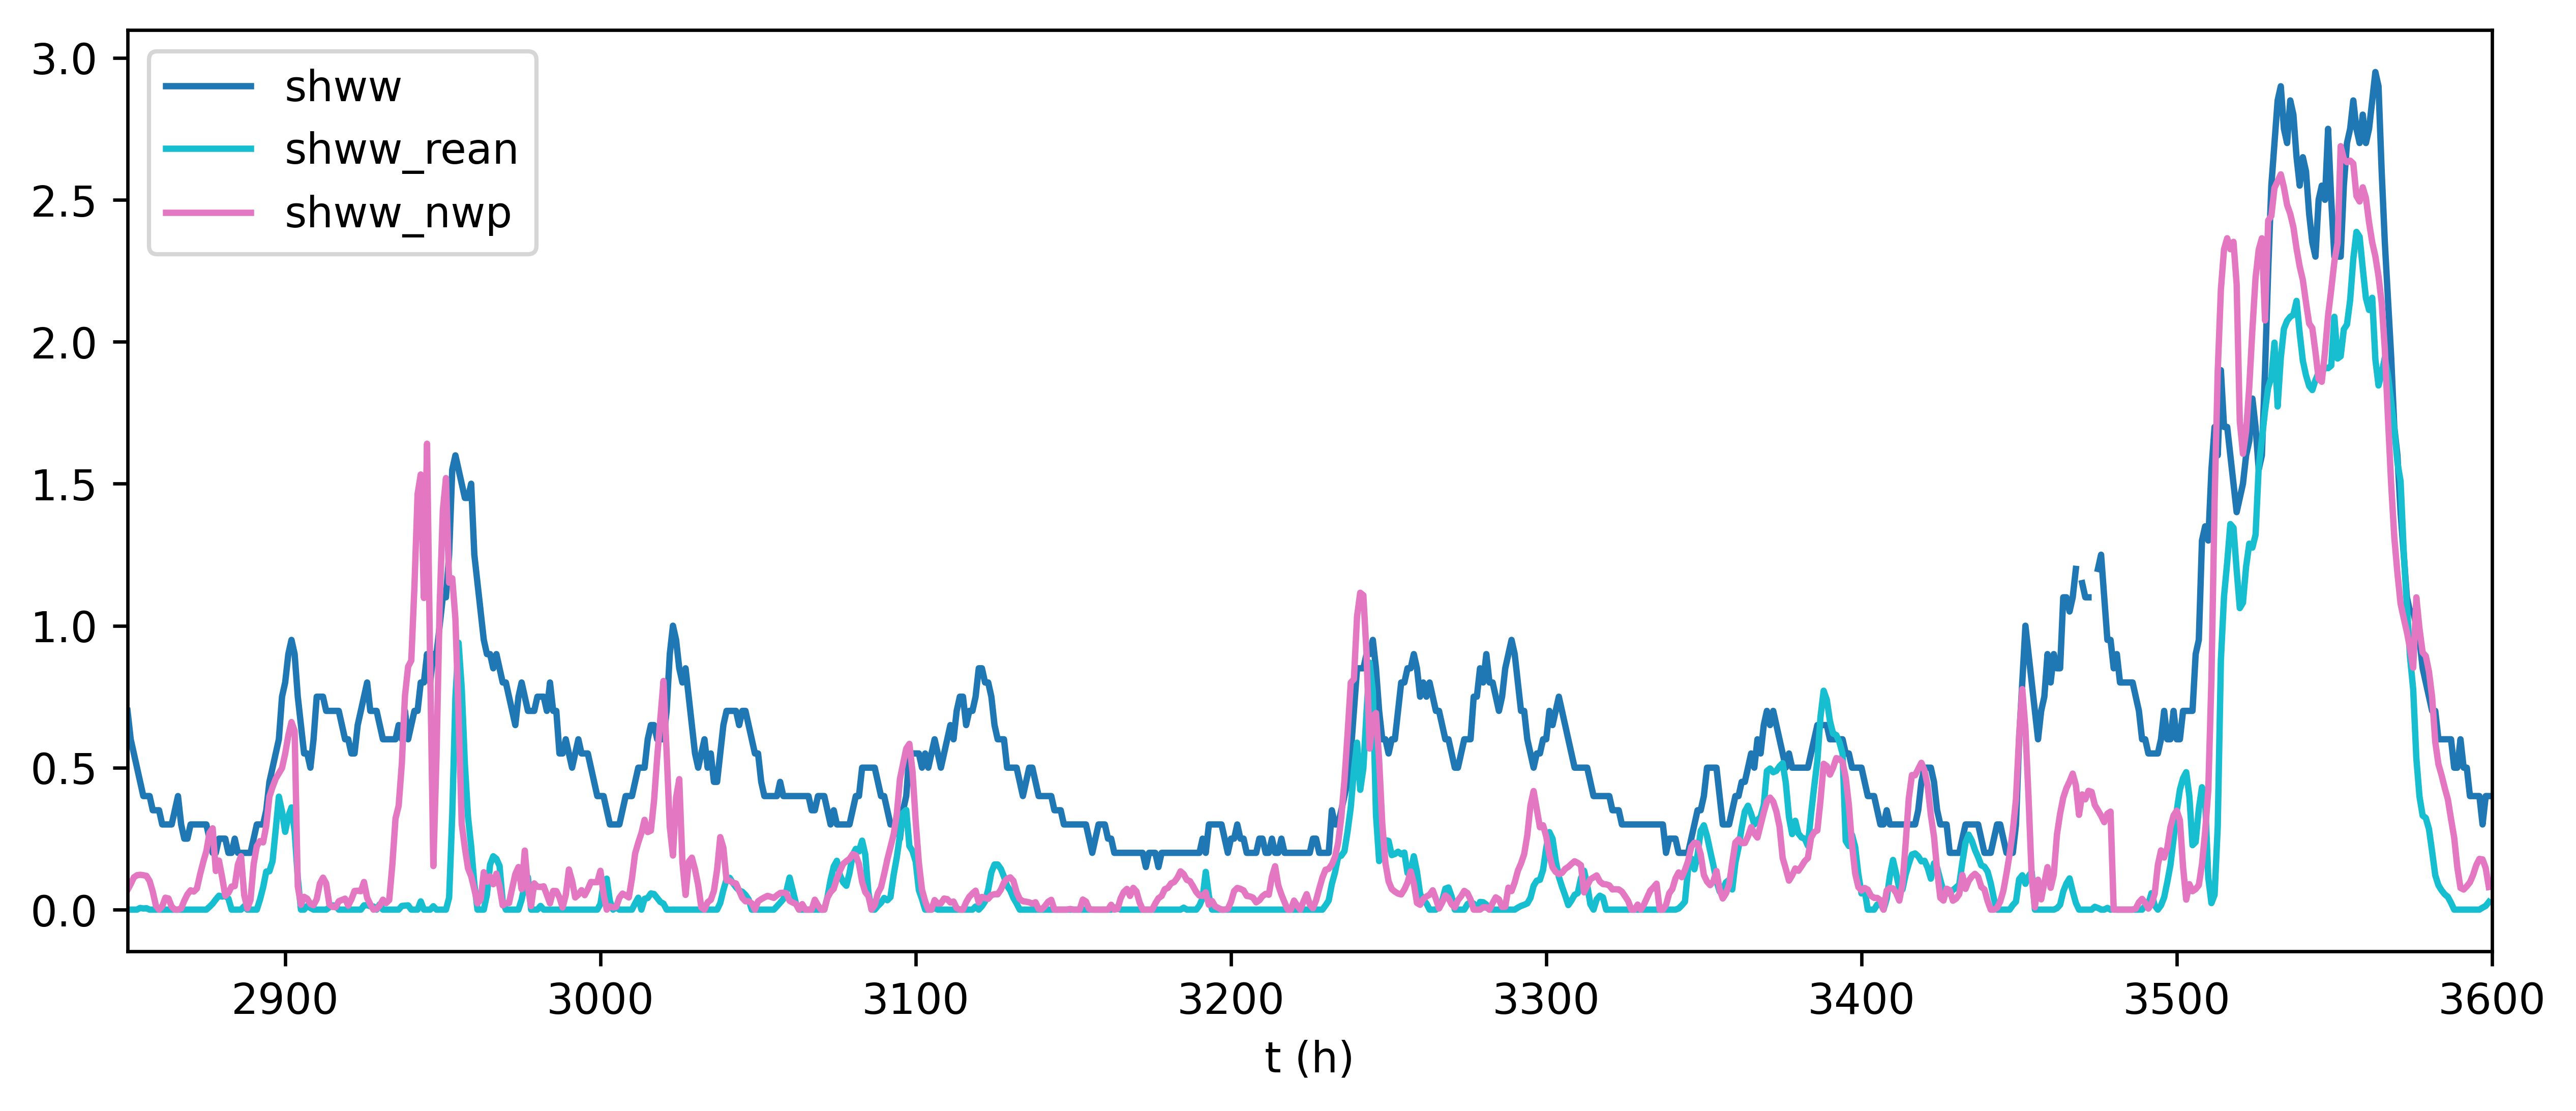

In [49]:
# %matplotlib auto

# series('T') # OK
# series('ws') # quite OK
# series('wd') # quite OK
series('shww') # correlated but slightly superior in general (same peaks but different low level)
# series('mpww') # pretty different (gap between obs and the two others)

In [64]:
%matplotlib auto

# histogram('T')
histogram('ws')

Using matplotlib backend: MacOSX


In [57]:
print('Observation | Reanalyses | NWP')
for cat in ['T', 'ws', 'wd', 'shww', 'mpww']:
    corr(cat)

Observation | Reanalyses | NWP
======== T correlations ========
[[1.         0.97591058 0.97706722]
 [0.97591058 1.         0.97605236]
 [0.97706722 0.97605236 1.        ]]
======== ws correlations ========
[[1.         0.75226653 0.80091372]
 [0.75226653 1.         0.79515828]
 [0.80091372 0.79515828 1.        ]]
======== wd correlations ========
[[1.         0.50409863 0.58099578]
 [0.50409863 1.         0.55232345]
 [0.58099578 0.55232345 1.        ]]
======== shww correlations ========
[[1.         0.68710719 0.71381961]
 [0.68710719 1.         0.86727265]
 [0.71381961 0.86727265 1.        ]]
======== mpww correlations ========
[[1.         0.13572459 0.17264185]
 [0.13572459 1.         0.76070931]
 [0.17264185 0.76070931 1.        ]]


In [58]:
print('Observation | Reanalyses | NWP')
for cat in ['T', 'ws', 'wd', 'shww', 'mpww']:
    RMSE(cat)

Observation | Reanalyses | NWP
============ T RMSEs ============
[[0.         0.84310274 0.78390138]
 [0.84310274 0.         0.75484871]
 [0.78390138 0.75484871 0.        ]]
============ ws RMSEs ============
[[0.         1.85283099 1.87317485]
 [1.85283099 0.         2.10757523]
 [1.87317485 2.10757523 0.        ]]
============ wd RMSEs ============
[[ 0.         89.67261304 88.20169791]
 [89.67261304  0.         85.74325721]
 [88.20169791 85.74325721  0.        ]]
============ shww RMSEs ============
[[0.         0.56732807 0.50151413]
 [0.56732807 0.         0.25472534]
 [0.50151413 0.25472534 0.        ]]
============ mpww RMSEs ============
[[0.         2.78501195 2.2509783 ]
 [2.78501195 0.         1.01409332]
 [2.2509783  1.01409332 0.        ]]


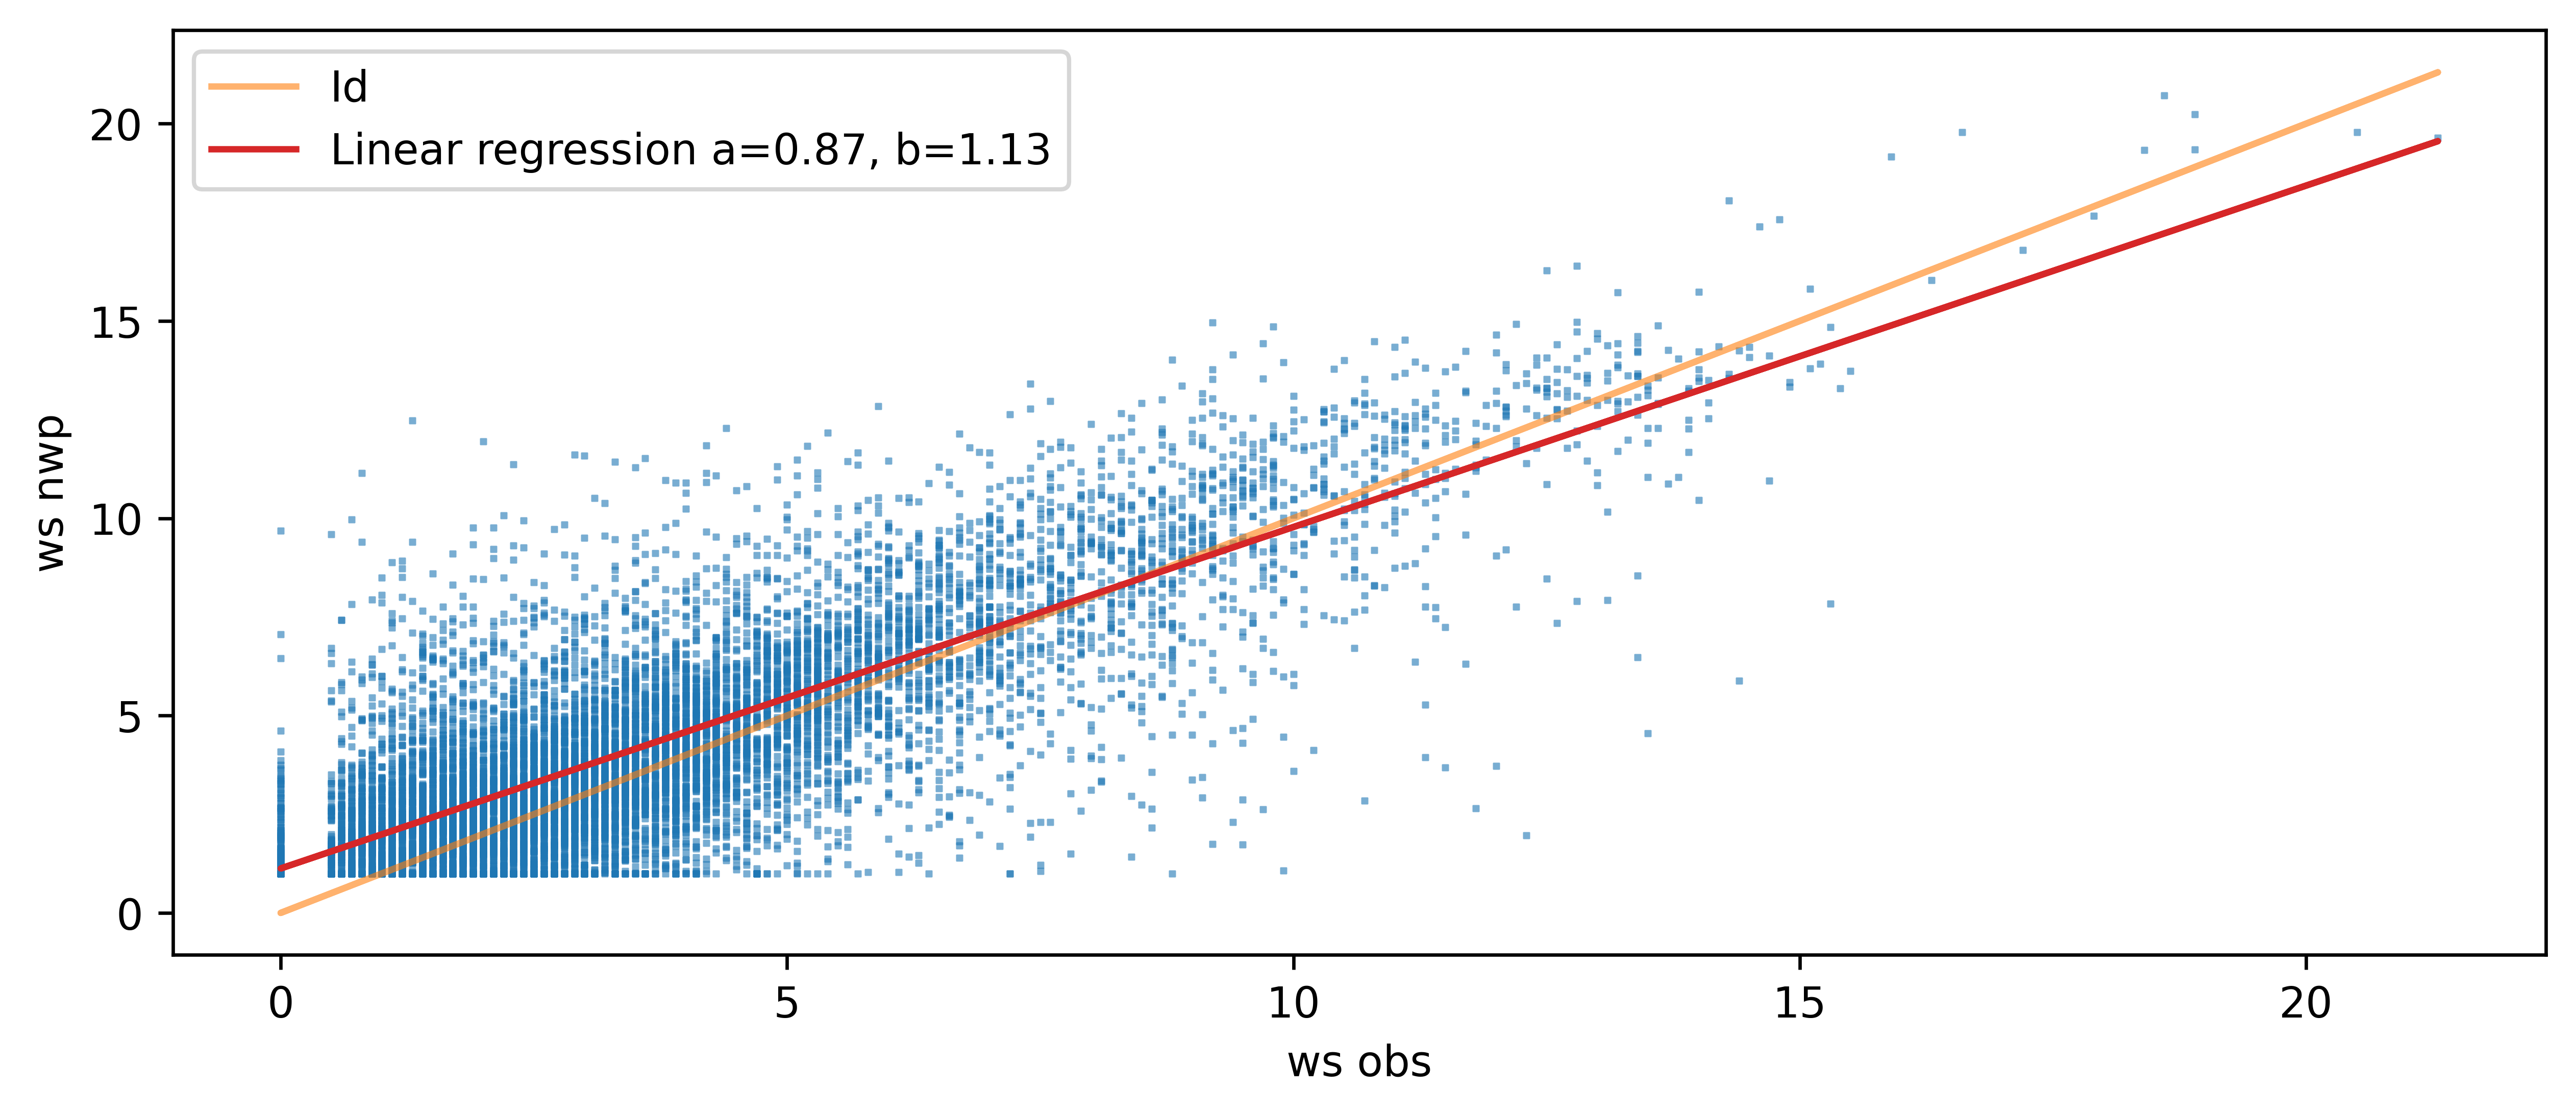

In [41]:
plane('ws')

### Centering

In [60]:
cen = pd.DataFrame()
for col in list(df.columns):
    if col in ['date', 'time', 'ghi', 'cs']:
        cen[col] = df[col]
    else:
        cen[col] = (df[col] - np.nanmean(df[col]))/np.nanstd(df[col])

In [61]:
# Histograms

for cat in ['T', 'ws', 'wd', 'shww', 'mpww']:
    histogram(cat, source=cen)

### Fourier transform

In [62]:
def fourier(cat: str, source: pd.DataFrame = df):

    # Filling gaps (and removing nans at the end)

    names = [cat + s for s in ['', '_rean', '_nwp']]
    data = source[names]
    masks = np.isnan(np.array(data, dtype='float'))
    anti = np.logical_not(masks)

    m = (data.index)[anti.all(axis=1)][-1] + 1 # last row not containing nan
    data = data.drop(labels=np.arange(m, 11016), axis=0)
    masks = masks[:m]
    anti = anti[:m]
    data = data.interpolate(method='linear', axis=0, limit_direction='both')

    # Figure

    fig, ax = plt.subplots(1, 2, sharey=False)
    ind = data.index

    # Plotting against time

    for k, name in enumerate(names):
        ax[0].plot(ind[anti[:, k]], data.loc[anti[:, k], name], label=name)
        ax[0].scatter(ind[masks[:, k]], data.loc[masks[:, k], name], label=name + ' filled', marker='o', s=5)
    ax[0].legend()
    ax[0].set_xlabel('t (h)')

    # Plotting against frequency

    freq = np.fft.fftfreq(m, 3600)
    fft = np.empty((3, m), dtype='float')
    for k, name in enumerate(names):
        ft = np.abs(np.fft.fft(data[name]))
        fft[k, :] = ft
        ax[1].plot(freq, ft, label=name + ' spectrum')
    ax[1].legend()
    ax[1].set_xlabel('f (Hz)')

    # Print correlation

    print('===== ' + cat + f' spectrums correlations ===== | {m} points kept')
    print(np.corrcoef(fft))

    fig.suptitle(cat + ' comparison')
    fig.show()

In [63]:
# Plot

%matplotlib auto

for cat in ['T', 'ws', 'wd', 'shww', 'mpww']:
    fourier(cat)

Using matplotlib backend: MacOSX
===== T spectrums correlations ===== | 11016 points kept
[[1.         0.99999873 0.99999894]
 [0.99999873 1.         0.9999988 ]
 [0.99999894 0.9999988  1.        ]]
===== ws spectrums correlations ===== | 11016 points kept
[[1.         0.96949217 0.97671709]
 [0.96949217 1.         0.97557651]
 [0.97671709 0.97557651 1.        ]]
===== wd spectrums correlations ===== | 11016 points kept
[[1.         0.96142975 0.9653053 ]
 [0.96142975 1.         0.96568828]
 [0.9653053  0.96568828 1.        ]]
===== shww spectrums correlations ===== | 8089 points kept
[[1.         0.84343104 0.89308151]
 [0.84343104 1.         0.96096285]
 [0.89308151 0.96096285 1.        ]]
===== mpww spectrums correlations ===== | 8089 points kept
[[1.         0.94560236 0.96886609]
 [0.94560236 1.         0.97745744]
 [0.96886609 0.97745744 1.        ]]


### Clear sky consistency test

In [64]:
# Time series

plt.figure()
plt.plot(df.index, df['cs'], label='cs')
plt.plot(df.index, df['cs_mod'], label='cs_mod')
plt.legend()
plt.xlabel('t (h)')
plt.ylabel('Clear sky GHI ($W \cdot m^{-2}$)')
plt.title('cs comparison')
plt.show()

# Correlation

print(np.corrcoef(np.array(df[['cs', 'cs_mod']].dropna(axis=0, how='any')).T)[0, 1])

# Regression

%matplotlib inline

plane('cs', 'mod', 'raw', source=df)

0.998088398737225


KeyError: "['cs_raw'] not in index"

### Wind as cartesian vector

In [ ]:
for suffix in ['', '_rean', '_nwp']:
    dir = np.pi*df['wd' + suffix]/180.
    df['wx' + suffix] = df['ws' + suffix]*np.cos(dir)
    df['wy' + suffix] = df['ws' + suffix]*np.sin(dir)

corr('wx')
corr('wy')

======== wx correlations ========
[[1.         0.74795014 0.81177937]
 [0.74795014 1.         0.80845393]
 [0.81177937 0.80845393 1.        ]]
======== wy correlations ========
[[1.         0.81686758 0.84675831]
 [0.81686758 1.         0.84066036]
 [0.84675831 0.84066036 1.        ]]


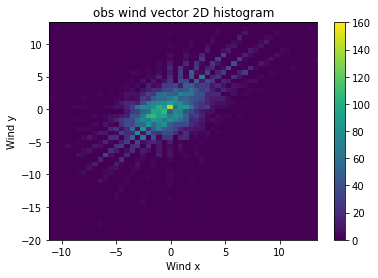

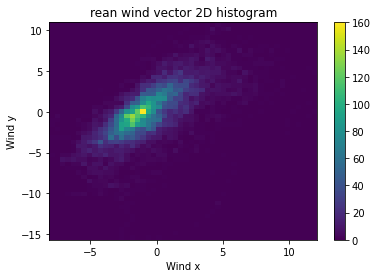

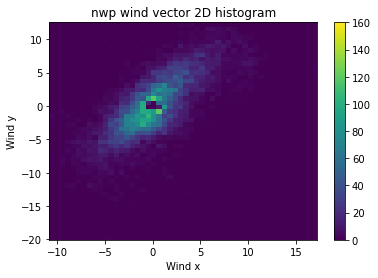

In [ ]:
for suffix in ['', '_rean', '_nwp']:
    
    data = df[['wx' + suffix, 'wy' + suffix]].dropna(axis=0, how='any')
    
    plt.figure()
    plt.hist2d(data['wx' + suffix], data['wy' + suffix], bins=(50, 50), vmax=160)
    plt.colorbar()
    plt.xlabel('Wind x')
    plt.ylabel('Wind y')
    desc = 'obs' if suffix == '' else suffix[1:]
    plt.title(desc + ' wind vector 2D histogram')

## 6. QCP

Purpose : removing potential absurd points in buoy data and check its consistency

### Check gaps

In particular, wind speed gaps between consecutive values must be less than $15 m \cdot s^{-1}$)

In [ ]:
def maxgap(cat: str, angle=False):
    if angle:
        gaps = np.abs(
            np.mod(
                np.array(df.loc[df.index[:-1], cat], dtype='float') - np.array(df.loc[df.index[1:], cat], dtype='float'),
                360
            ) - 180
        )
    else:
        gaps = np.abs(
            np.array(df.loc[df.index[:-1], cat], dtype='float') - np.array(df.loc[df.index[1:], cat], dtype='float'),
        )
    return np.nanmax(gaps)

In [ ]:
for cat in ['T', 'shww', 'mpww', 'wx', 'wy', 'ws']:
    print(cat + ' max gap : {:.2f}'.format(maxgap(cat)))
print('wd max gap : {:.2f}'.format(maxgap('wd', True)))

T max gap : 7.00
shww max gap : 1.10
mpww max gap : 3.00
wx max gap : 13.43
wy max gap : 18.65
ws max gap : 11.40
wd max gap : 180.00


### Check extrema

In [ ]:
def extrema(cat: str):
    values = np.array(df[cat], dtype='float')
    return np.nanmin(values), np.nanmax(values)

In [ ]:
for cat in ['T', 'wx', 'wy', 'ws', 'wd', 'shww', 'mpww']:
    mini, maxi = extrema(cat)
    print(cat + ' extreme values : {:.2f} - {:.2f}'.format(mini, maxi))

T extreme values : 283.55 - 304.95
wx extreme values : -11.13 - 13.44
wy extreme values : -20.02 - 13.29
ws extreme values : 0.00 - 21.30
wd extreme values : 0.00 - 360.00
shww extreme values : 0.10 - 4.00
mpww extreme values : 2.90 - 9.00


### Check nans

In [ ]:
dnan = {
    name: np.count_nonzero(df[name].isna()) for name in df.columns if name not in ['date', 'time']
}
for n, v in dnan.items():
    if v > 0:
        print(n + f' --> {v} missing values')

shww_rean --> 2927 missing values
mpww_rean --> 2927 missing values
ws --> 275 missing values
wd --> 275 missing values
shww --> 210 missing values
mpww --> 210 missing values
T --> 249 missing values
wx --> 275 missing values
wy --> 275 missing values


In [ ]:
windMissing = df['ws'].isna() | df ['wd'].isna()
(df['ws'].isna() == df['wd'].isna()).all()

True

In [ ]:
ind = df[windMissing].index
for i in ind:
    prev = i - 1 in ind
    foll = i + 1 in ind
    if prev and not foll:
        print(f' - {i}')
    elif foll and not prev:
        print(f'{i}', end='')

371 - 375
1728 - 1751
3443 - 3444
3446 - 3447
3449 - 3453
3455 - 3457
3464 - 3465
3472 - 3474
3483 - 3484
3497 - 3504
3514 - 3518
4552 - 4567
5099 - 5102
5108 - 5109
5112 - 5113
7280 - 7288
7431 - 7433
7829 - 7830
7833 - 7834


In [ ]:
ind = df[df['T'].isna()].index
for i in ind:
    prev = i - 1 in ind
    foll = i + 1 in ind
    if prev and not foll:
        print(f' - {i}')
    elif foll and not prev:
        print(f'{i}', end='')

1728 - 1751
3443 - 3444
3446 - 3447
3449 - 3453
3455 - 3457
3464 - 3465
3472 - 3474
3483 - 3484
3497 - 3504
3514 - 3518
4552 - 4567
7280 - 7288
7431 - 7433
7829 - 7830
7833 - 7834


In [ ]:
ind = df[df['shww'].isna() | df ['mpww'].isna()].index
for i in ind:
    prev = i - 1 in ind
    foll = i + 1 in ind
    if prev and not foll:
        print(f' - {i}')
    elif foll and not prev:
        print(f'{i}', end='')

1728 - 1751
3473 - 3474
4552 - 4567
7280 - 7288
7431 - 7433
7829 - 7830
7833 - 7834


In [ ]:
ind = df[df['shww_rean'].isna() | df ['mpww_rean'].isna()].index
for i in ind:
    prev = i - 1 in ind
    foll = i + 1 in ind
    if prev and not foll:
        print(f' - {i}')
    elif foll and not prev:
        print(f'{i}', end='')

8089 - 11015
